### Data EDA

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import sklearn
import tqdm.notebook as tqdm
import torch

In [9]:
#load ecg data
import wfdb

# Specify the file path without the extension (it will look for .dat and .hea automatically)
record_name = ecg_dir = "/projects/bdlo/music-sudden-cardiac-death/Holter_ECG/P0002"

# Load the signal and header info
record = wfdb.rdrecord(record_name)  # Loads both .dat and .hea files
signal = record.p_signal  # Get the ECG signal (numpy array)
fields = record.__dict__  # Access additional metadata (like sampling frequency)

print("Signal Shape:", signal.shape)

#trim
fs = fields['fs']
trim_seconds = 35
trim_samples = int(fs * trim_seconds)

signal = signal[trim_samples : -trim_samples]
print(signal.shape)
fields['sig_len'] = signal.shape

# Display basic info, should be 16217800, 3
print("Signal Shape:", signal.shape)
print("Sampling Frequency:", record.fs)
print("Channel Names:", record.sig_name)


Signal Shape: (16217800, 3)
(16203800, 3)
Signal Shape: (16203800, 3)
Sampling Frequency: 200
Channel Names: ['X', 'Y', 'Z']


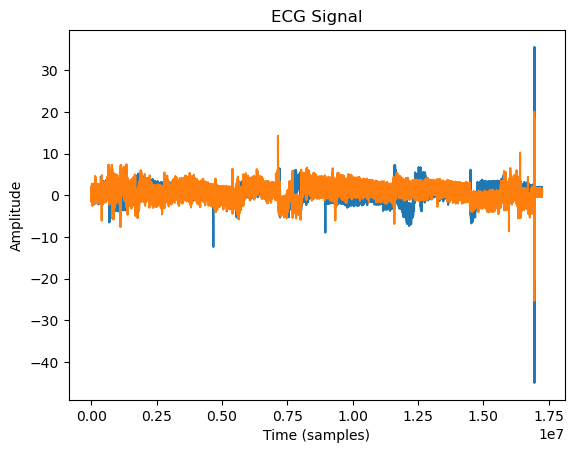

In [3]:
plt.plot(signal)
plt.title("ECG Signal")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.show()

### Dataloader

In [3]:
#TRANSFORMS TAKEN FROM ESI

import math
import numpy as np
import torch
import torch.optim as optim


class Jitter(object):
    def __init__(self, sigma=0.03):
        self.sigma = sigma

    def jitter(self, x, sigma):
        # Jitter is added to every point in the time series data, so no change is needed based on channel_first
        return x + np.random.normal(loc=0., scale=sigma, size=x.shape)
    
    def __call__(self, x):
        return self.jitter(x, self.sigma)


class Scaling(object):
    def __init__(self, sigma=0.1, channel_first=False):
        self.sigma = sigma
        self.channel_first = channel_first

    def scaling(self, x, sigma):
        factor = np.random.normal(loc=1., scale=sigma, size=(1, x.shape[1]))  # Shape: (1, C)
        return np.multiply(x, factor)
    
    def __call__(self, x):
        return self.scaling(x, self.sigma)
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        sample = torch.Tensor(sample)
        return sample
    

class TwoCropTransform:
    """Create two crops of the same image"""
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, x):
        return [self.transform(x), self.transform(x)]
    
def normalize(signal):
    mean = signal.mean(dim=-1, keepdim=True)  # Mean along time axis
    std = signal.std(dim=-1, keepdim=True)
    return (signal - mean) / (std + 1e-6)  # Avoid division by zero


In [4]:
import os
import torch
import numpy as np
import pandas as pd
import wfdb
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class HolterECGLoader(Dataset):
    def __init__(self, csv_file, ecg_dir, chunk_size = 1000, target_length=12000000):
        """
        ECG Dataset that returns one 5-second segment per call and moves sequentially to the next patient.

        Args:
            csv_file (str): Path to the CSV file containing metadata.
            ecg_dir (str): Path to the directory containing ECG records.
            segment_length (int): Length of ECG segments in seconds.
            augmentation (bool): Whether to apply augmentation.
        """
        super().__init__()
        self.dataset = pd.read_csv(csv_file, index_col=0)
        self.label_dict = {0: 0, 3: 1, 6: 2}
        self.ecg_dir = ecg_dir
        
        self.chunk_size = chunk_size
        self.target_length = target_length 

        self.transform = transforms.Compose([
            ToTensor(),
        ])

    def __len__(self):
        """
        Returns the number of patients since the dataloader will iterate per patient, not per segment.
        """
        return len(self.dataset)


    def mean_impute(self, ecg_signal):
        """Impute missing values in a 3-channel ECG using mean imputation."""
        mask = torch.isnan(ecg_signal)  # Find missing values
        mean_values = torch.nanmean(ecg_signal, dim=0, keepdim=True)  # Compute mean per channel
        ecg_signal[mask] = mean_values.expand_as(ecg_signal)[mask]  # Replace NaNs with per-channel mean
        return ecg_signal

    
    def load_ecg(self, ecg_filename): 
        # Load patient ECG file
        record = wfdb.rdrecord(ecg_filename)
        signal = record.p_signal  
        fs = record.fs  

        # Trim first and last 30 seconds
        trim_samples = fs * 30
        signal = signal[trim_samples:-trim_samples]
    
        # Ensure the signal is at least target_length
        if signal.shape[0] > self.target_length:
            signal = signal[:self.target_length, :]
        elif signal.shape[0] < self.target_length:
            pad_length = self.target_length - signal.shape[1]
            signal = np.pad(signal, ((0, 0), (0, pad_length)), mode='constant')
        
        return signal, fs
        

    def __getitem__(self, idx):
        """
        Returns one 5-second segment from the current patient's ECG.
        Moves to the next patient after all segments of the current one are processed.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        #load
        ecg_filename = os.path.join(self.ecg_dir, self.dataset.iloc[idx, 0])
        label = self.label_dict[self.dataset.iloc[idx, 4]]
        signal, fs = self.load_ecg(ecg_filename)
        
        #transform
        signal = self.transform(signal)
        signal = self.mean_impute(signal)
        signal = normalize(signal)
    
        
        #from (seq_length, 3) to (3, num chunks, chunk size) NONOVERLAPPING SEGMENTS
        signal = signal.unfold(dimension=0, size=self.chunk_size, step=self.chunk_size - 100)
        return signal, label 

#1. ECGchunks using 1D CNN --> 
#2. Flatten and then classify  (1, chunksize * embed)

In [5]:
csv_path = "/projects/bdlo/music-sudden-cardiac-death/subject-info-cleaned.csv"
ecg_dir = "/projects/bdlo/music-sudden-cardiac-death/Holter_ECG"

holterecg_dataset = HolterECGLoader(csv_file=csv_path, ecg_dir=ecg_dir)
#test - works
signal, label = holterecg_dataset[1]
sample_idx = 300
signal.shape


torch.Size([13333, 3, 1000])

### Model

In [6]:
import importlib.metadata
import json
import logging
import os
import re
import tempfile
import time
import ast
from pathlib import Path
from typing import Any, Callable, Dict, List, Literal, Optional, Tuple, Type, TypeVar, Union, Collection

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import sklearn
import tqdm.notebook as tqdm
import torch

Floats = Union[float, List[float]]


In [7]:
import torch
import torch.nn as nn

class ECG_downsampler(nn.Module):
    def __init__(self, output_segments=1000):
        """
        ARGS:
            output_segments: Number of segments to retain after downsampling.
        """
        super().__init__()

        #aggressive downsampling
        #instance norm samples each segment independently, ensuring no bleeding
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=16, kernel_size=25, stride=20, padding=12)
        self.pool1 = nn.MaxPool1d(kernel_size=10, stride=10)  # Reduce faster
        self.norm1 = nn.InstanceNorm1d(16)  # Prevents batch mixing

        self.conv2 = nn.Conv1d(in_channels=16, out_channels=3, kernel_size=5, stride=1, padding=2)
        self.norm2 = nn.InstanceNorm1d(3)

        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        """
        ARGS:
            x: Input ECG signal shape (batch, 3, num_segments, temporal)
        
        RETURNS: (batch, 3, output_segments)
        """

        batch_size, num_leads, num_segments, time_dim = x.shape

        # flattens x, so that x is all segments in the batch
        x = x.reshape(batch_size * num_segments, num_leads, time_dim)  # Merge batch & segments

        # downsample time dim, using adaptive pooling
        x = self.pool1(self.norm1(self.conv1(x)).relu())  
        x = self.norm2(self.conv2(x)).relu()  

        # force the time dim to 1, so it is (batchsize * num_segments, 3, 1)
        x = self.adaptive_pool(x)  

        # remove last dim
        x = x.squeeze(-1) 

        num_segments = x.shape[0] // batch_size  
        #reshape to get original sizes
        x = x.contiguous().view(batch_size, num_segments, num_leads)  
        
        
        # switch axis for input to encoder(batch, 3, num_segments)
        x = x.permute(0, 2, 1)  

        return x

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class XResNet1D(nn.Module):
    
    #INPUT IS (batch, 3, ecg_length)
    def __init__(self, in_channels=3, num_classes=3, layers=[2, 2, 2, 2]):
        super(XResNet1D, self).__init__()

        self.inplanes = 64
        self.conv1 = nn.Conv1d(in_channels,out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        # Define ResNet blocks
        self.layer1 = self._make_layer(64, layers[0])
        self.layer2 = self._make_layer(128, layers[1], stride=2)
        self.layer3 = self._make_layer(256, layers[2], stride=2)
        self.layer4 = self._make_layer(512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, planes, blocks, stride=1):
        layers = []
        layers.append(self._residual_block(self.inplanes, planes, stride))
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(self._residual_block(planes, planes))
        return nn.Sequential(*layers)

    def _residual_block(self, in_planes, out_planes, stride=1):
        return nn.Sequential(
            nn.Conv1d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm1d(out_planes),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_planes, out_planes, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm1d(out_planes)
        )

    def forward(self, x):
        x = self.conv1(x)  # Initial Conv Layer
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)  # Residual Blocks
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)  # Global Pooling
        x = torch.flatten(x, 1)
        x = self.fc(x)  # Classification Head
        return x


In [9]:
import torch
import torch.nn as nn

class ECG_Encoder(nn.Module):
    def __init__(self, ecg_downsampler = ECG_downsampler, encoder_model = XResNet1D):
        super().__init__()
        self.ecg_downsampler = ecg_downsampler
        self.encoder_model = encoder_model

    def forward(self, x):
        """
        ARGS:
            x: Input ECG of shape (batch_size, num_segments, 3, temporal)
        RETURNS: num_classes
        """
        
        #input is (batch, num_seg, 3, time)
        batch_size, num_segments, num_leads, time_dim = x.shape  # Unpack shape

        # process each ECG segment independently through downsampler
        x = x.permute(0, 2, 1, 3)  # move num_leads forward --> (batch, 3, num_segments, temporal)
        
        #input should be (batch, 3, num_segments, temporal)
        x = self.ecg_downsampler(x)  

        # resnet
        x = self.encoder_model(x) 

        return F.log_softmax(x, dim = 1)
    


## Training Step

In [10]:
!nvidia-smi

Thu Feb 27 00:50:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A40                     On  |   00000000:C7:00.0 Off |                    0 |
|  0%   31C    P8             21W /  300W |       1MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support
from tqdm import tqdm  # For progress bar
import warnings
warnings.filterwarnings("ignore")


#one epoch
def one_train_epoch(model, dataloader, criterion, optimizer, scheduler, device, clip_grad=1.0):
    model.train()  # Set model to training mode
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []

    # Progress bar
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc="Training", leave=True)

    for batch_idx, (x, y) in pbar:
        x, y = x.to(device), y.to(device)  # Move to GPU if available
        
        optimizer.zero_grad()  
        outputs = model(x)  # Shape: (batch_size, num_classes)
        
        loss = criterion(outputs, y)
        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)  
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        
        probs = torch.exp(outputs)
        all_probs.extend(probs.detach().cpu().numpy())

        loss.backward()  
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
        optimizer.step() 

        pbar.set_postfix({"Loss": f"{loss.item():.4f}"})

    # Compute final metrics
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs, multi_class="ovr", average="macro")
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro", zero_division=1)

    scheduler.step(avg_loss)
    
    print(f"Train Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
    print(f"AUC Score: {auc:.4f}\n")

    return avg_loss, accuracy, precision, recall, f1


In [ ]:
def one_test_epoch(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []

    # Progress bar
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc="Testing", leave=True)

    with torch.no_grad():  # Disable gradient calculations
        for batch_idx, (x, y) in pbar:
            x, y = x.to(device), y.to(device)  # Move to GPU if available
            
            outputs = model(x)  # Shape: (batch_size, num_classes)
            loss = criterion(outputs, y)  # Compute loss
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)  # Get predicted class
            probs = torch.exp(outputs)  # Convert log-softmax to probabilities

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

            pbar.set_postfix({"Loss": f"{loss.item():.4f}"})

    # Compute final metrics
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs, multi_class="ovr", average="macro")
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="macro", zero_division=1)

    print(f"\nTest Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
    print(f"AUC Score: {auc:.4f}\n")

    return avg_loss, accuracy, precision, recall, f1, auc


In [ ]:
batch_size = 3
seg_length = 1000  
num_classes = 3
lr = 0.001
weight_decay = 1e-4
target_length = 12000000
num_epochs = 100

device = "cuda:0"
ecg_downsampler = ECG_downsampler()
encoder_model = XResNet1D()
model = ECG_Encoder(ecg_downsampler = ecg_downsampler, encoder_model = encoder_model).to(device)

criterion = torch.nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr = lr, weight_decay = weight_decay) 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

#train loader
train_idx, val_idx = sklearn.model_selection.train_test_split(list(range(len(holterecg_dataset))), test_size=0.2, stratify=holterecg_dataset.dataset["Cause of death"])
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
holterecg_dataset = HolterECGLoader(csv_file=csv_path, ecg_dir = ecg_dir, chunk_size = seq_length, target_length = target_length)
train_loader = DataLoader(holterecg_dataset, batch_size= batch_size, num_workers=2, sampler=train_sampler)

val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_idx)
val_loader = DataLoader(holterecg_dataset, batch_size = batch_size, num_workers=2, sampler=val_sampler)


#output is (batch, num seg, 3, temporal])

for i in range(num_epochs):
    print("Epoch: %s" %i)
    one_train_epoch(model = model, 
                    dataloader = train_loader, 
                    criterion = criterion, 
                    optimizer = optimizer, 
                    scheduler = scheduler, 
                    device = device, 
                    clip_grad=1.0)
    
    one_test_epoch_epoch(model = model, 
                         dataloader = train_loader, 
                         criterion = criterion, 
                         optimizer = optimizer, 
                         scheduler = scheduler, 
                         device = device)
    print("-------------------------")

Epoch: 0


Training: 100%|██████████| 156/156 [14:53<00:00,  5.73s/it, Loss=0.0654]



 Train Loss: 0.8312
Accuracy: 0.68%
Precision: 0.3617, Recall: 0.3539, F1-score: 0.3540
AUC Score: 0.5502

Epoch: 1


Training: 100%|██████████| 156/156 [14:48<00:00,  5.69s/it, Loss=0.0945]



 Train Loss: 0.7606
Accuracy: 0.80%
Precision: 0.9328, Recall: 0.3333, F1-score: 0.2959
AUC Score: 0.4040

Epoch: 2


Training: 100%|██████████| 156/156 [13:32<00:00,  5.21s/it, Loss=0.1202]


 Train Loss: 0.7230
Accuracy: 0.80%
Precision: 0.9328, Recall: 0.3333, F1-score: 0.2959
AUC Score: 0.4998

Epoch: 3



Training:   5%|▌         | 8/156 [00:47<13:02,  5.29s/it, Loss=0.1087]